In [1]:
import seaborn as sns
import pandas as pd


In [2]:
sub1 = pd.read_csv('../output/1214-1.csv.gz')
sub2 = pd.read_csv('../output/1215-1.csv.gz')


In [3]:
tmp = sub1.iloc[:,1:].sum(1) - sub2.iloc[:,1:].sum(1)

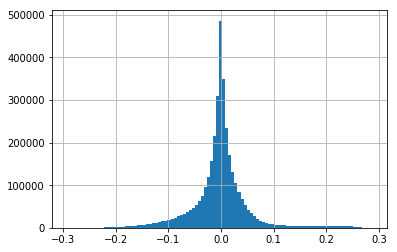

In [4]:
tmp.hist(bins=100)